# COMPLEX - CONTAGION

#### Group project: Physics and dynamics of complex networks

In this jupyter notebook we reproduce the results of the Ref: *Watts, Duncan J. "A simple model of global cascades on random networks." Proceedings of the National Academy of Sciences 99.9 (2002): 5766-5771.*

#### Libraries

In [1]:
library(igraph) # for graphs
library(tidyverse) # for working with dataframes
library(ggplot2) # for plots
library(dplyr) #for queries


Caricamento pacchetto: ‘igraph’


I seguenti oggetti sono mascherati da ‘package:stats’:

    decompose, spectrum


Il seguente oggetto è mascherato da ‘package:base’:

    union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%--%()      masks igraph::%--%()
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


#### Functions for the contagion evolution

In [2]:
#this functions implants the seed of state 1 in the network, 
#by random as deafault 
#and as many sees as many is specified by the parameter n.seed

seed <- function(nodes.state, n.seeds = 1, method = 'random'){
    
    N <- length(nodes.state)
    
    if (method == 'random'){
        seeds.id <- sample.int(N, n.seeds)
    }
    
    nodes.state[seeds.id] <- 1
    
    return(nodes.state)
}

In [3]:
#this function is meanted for networks that do not 
#change their structure during the evolution of the dynamics.
#The function update the state of each node of a threshold based 
#on his neighbours and on the node threshold

update <- function(nodes.state, nodes.threshold, nodes.neighbors){
    
    N <- length(nodes.state)
    
    nodes.state.in <- nodes.state
    
    nodes.state.out <- nodes.state
    
    for (i in 1:N){
    
        if (nodes.state[i] != 1){
            
            if(length(nodes.neighbors[[i]])!=0){
        
                if(sum(nodes.state.in[nodes.neighbors[[i]]])/length(nodes.neighbors[[i]]) >= nodes.threshold[i]){
                    nodes.state.out[i] <- 1
                }
            }          
        
        }
    
    }
    
    return(nodes.state.out) 
}


## SIMULATIONS

### Simulation of random graph networks with uniform threshold

#### Parameters of the simulation

In [4]:
n <- 10000 #number of nodes
threshold.list <- seq(from = 0.1, to = 0.26, by=0.01) #values of threshold used
z.list <- seq(from=1, to=30, by=1) #values of avarage degree used
max.update <- 100   #maximum number of updates
n.seeds <- 1 # number of initial seeds
n.run <- 10 #number of runs for each set of parameters
filename <- 'ERG_simulation_data.csv' # file in which to save the results

#### Simulation

## Studying the time of evolution as function of the avarage degree z

#### Parameters of the simulation

In [5]:
n <- 10000 #number of nodes
threshold.list <- c(0.18) #values of threshold used
z.list <- seq(from=0.5, to=7, by=0.1) #values of avarage degree used
max.update <- 100   #maximum number of updates
n.seeds <- 1 # number of initial seeds
n.run <- 10 #number of runs for each set of parameters
filename <- 'ERG_simulation_time.csv' #file name in whoch to save data

## Simulations with normal distributed threshold

#### Parameters of the simulation

In [6]:
n <- 10000 #number of nodes
threshold.list <- seq(from = 0.1, to = 0.3, by=0.02)  #mean of the threshold
z.list <- seq(from=1, to=15, by=1) #avarage degree used
max.update <- 100   #maximum number of updates
n.seeds <- 1 # number of initial seeds
n.run <- 10 #number of runs for each set of parameters
filename <- 'ERG_simulation_sigma0.05.csv' #file in which save the results
sd <- 0.05  #standard deviation 

#### Simulation

## Simulation with Barabasi-Albert model

#### Parameters of the simulation

In [7]:
n <- 10000 #number of nodes
threshold.list <-seq(from = 0.02, to = 0.1, by=0.02) #threshold list
m.list <- seq(from=1, to=15, by=1) # z=2m for a Barabasi Albert model
max.update <- 100   #maximum number of updates
n.seeds <- 1 # number of initial seeds
n.run <- 10 #number of runs for each set of parameters
filename <- 'BA_simulation_data2.csv'

#### Simulation

## DATA ANALYSIS

### Random graph networks with uniform threshold cascade phase space

#### Data cleaning

In [8]:
filename <- 'data/ERG_simulation_data.csv'  # file with data
#reading the data
df <- read.csv(filename)
#cleaning the data
data <- df %>% group_by(threshold, z)%>% 
    arrange(desc(cascade.fraction), .by_group=TRUE) %>% 
    filter(row_number()==1)

#selecting systems that show cascade and not
cascade <- data %>% filter(cascade.fraction>=0.1)
no_cascade <- data %>% filter(cascade.fraction <0.1)

#### Theoretical prediction

In [9]:
##Gamma incomplete function with upper and lower specification for different branch

gamma_inc <- function(a, x, type='upper'){
    out <- 0
    if(type=='upper'){
        out <- integrate(integrand, a=a, x, Inf)
    }
    else if(type=='lower'){
        out <- integrate(integrand, a=a, 0, x)
    }
    return(out$value)
}

In [10]:
#integrand in the gamma incomplete function
integrand <- function(t, a){
    return(t^(a-1)*exp(-t))
}

In [11]:
#theoretical cascade condition: condition==0
condition <- function(z, phi, type='upper'){
    out <- 0
    if(type=='upper'){
        out <- z*gamma_inc(floor(1/phi)-1, z, 'upper')-1
    }
    else if(type=='lower'){
        out <- z*gamma_inc(floor(1/phi)-1, z, 'lower')-1
    }
    return(out)
}

In [12]:
#Parameters for numerical solution of the condition
lower_z=1  #lower value of z
upper_z=40  #upper values of z
n_intervals=1000  #number of intervals
phi.list <- seq(from = 0.1, to = 0.25, by=0.001) #list of threshold considered

In [13]:
#Upper branch of the gamma incomplete function roots
z.roots.upper <- c()
phi.roots.upper <- c()
for(phi in phi.list){

    h <- (upper_z-lower_z)/n_intervals
    segments <- seq(from= lower_z, to=upper_z, by=h)

    for (i in 1:(n_intervals-1)){
        if(condition(segments[i], phi, 'upper')*condition(segments[i+1], phi, 'upper')<0){
            zero <- uniroot(condition, phi=phi, type='upper', lower=segments[i], upper=segments[i+1])$root
            z.roots.upper <- c(z.roots.upper, zero)
            phi.roots.upper <- c(phi.roots.upper, phi)
        }
    }
}

In [14]:
#Lower branch of the gamma incomplete function roots
z.roots.lower <- c()
phi.roots.lower <- c()
for(phi in phi.list){

    h <- (upper_z-lower_z)/n_intervals
    segments <- seq(from= lower_z, to=upper_z, by=h)

    for (i in 1:(n_intervals-1)){
        if(condition(segments[i], phi, 'lower')*condition(segments[i+1], phi, 'lower')<0){
            zero <- uniroot(condition, phi=phi, type='lower', lower=segments[i], upper=segments[i+1])$root
            z.roots.lower <- c(z.roots.lower, zero)
            phi.roots.lower <- c(phi.roots.lower, phi)
        }
    }
}

In [15]:
#Saving the theory prediction
teor.lower <- data.frame(phi.roots.lower, z.roots.lower)
teor.upper <- data.frame(phi.roots.upper, z.roots.upper)

#### Comparison between theoretical prediction and data from the simulations

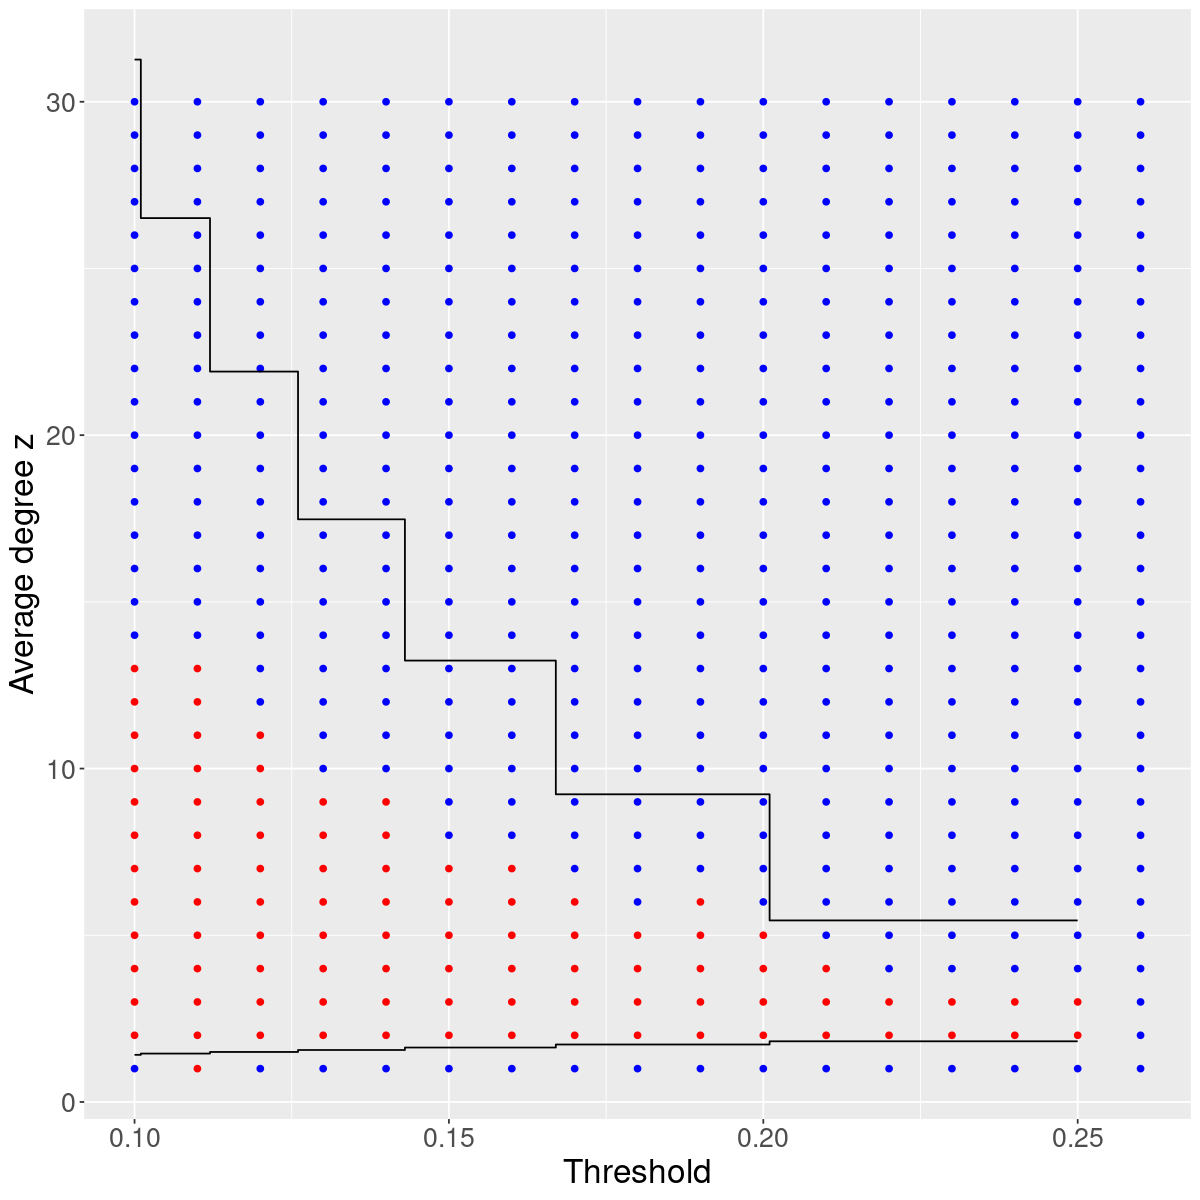

In [16]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot() +
    geom_point(data = cascade, aes(x=threshold,y=z, colour='Empirical cascade'), col='red')+
    geom_point(data = no_cascade, aes(x=threshold,y=z, colour='No empirical cascade'), col='blue')+
    geom_step(data=teor.lower, aes(x=phi.roots.lower, y=z.roots.lower), col='black')+
    geom_step(data=teor.upper, aes(x=phi.roots.upper, y=z.roots.upper), col='black')+
    xlab(label = 'Threshold')+
    ylab(label = 'Average degree z')+
    theme(text = element_text(size = 20)) 

### Phase transitions

In [17]:
filename <- 'data/ERG_simulation_time.csv'

df <- read.csv(filename)
times <- df %>% group_by(z) %>% summarize(mean_time=mean(time)-2) 
#mean(time)-2 beacuase of how time is accounted in simulations

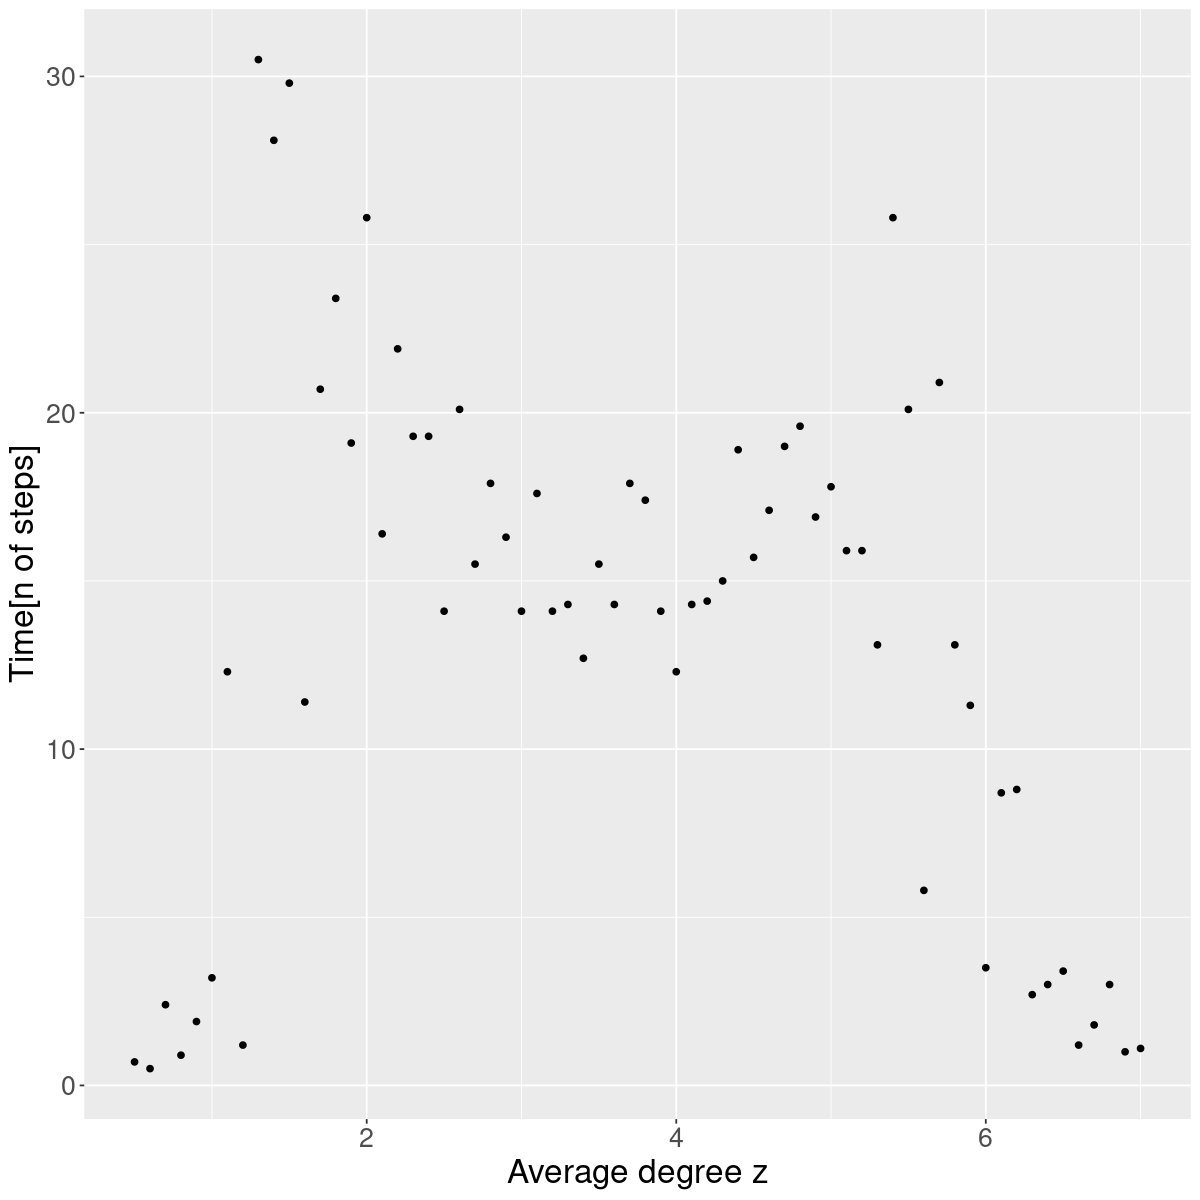

In [18]:
ggplot()+
    geom_point(data=times, aes(x=z, y=mean_time))+
    xlab(label = 'Average degree z')+
    ylab(label = 'Time[n of steps]')+
    theme(text = element_text(size = 20)) 

### Connected component and cascade failure size comparison

#### Extracting network with observed cascade failure

In [19]:
filename <- 'data/ERG_simulation_time.csv'

df <- read.csv(filename)

#selecting only the simulations with cascade failures
df.cascade <- df %>% filter(cascade.fraction>0.1)

#### Theoretical prediction of connected component

In [20]:
#Condition for connected componente size: condition==0
connected_component <- function(S, z){
    return(S-1+exp(-z*S))
}

In [21]:
#Parameters to solve the connect component size
z <- seq(1.1, 7, by=0.1)
lower <- rep(0.1, length(z))
upper <- rep(1, length(z))

In [22]:
#Solution of connected component size
S <- c()
for (i in seq_along(z)){
    root <- uniroot(connected_component, z=z[i], lower=lower[i], upper=upper[i])$root
    S <- c(S, root )
    }
prediction <- data.frame(z, S)

#### Comparison between theoretical prediction and data from the simulations

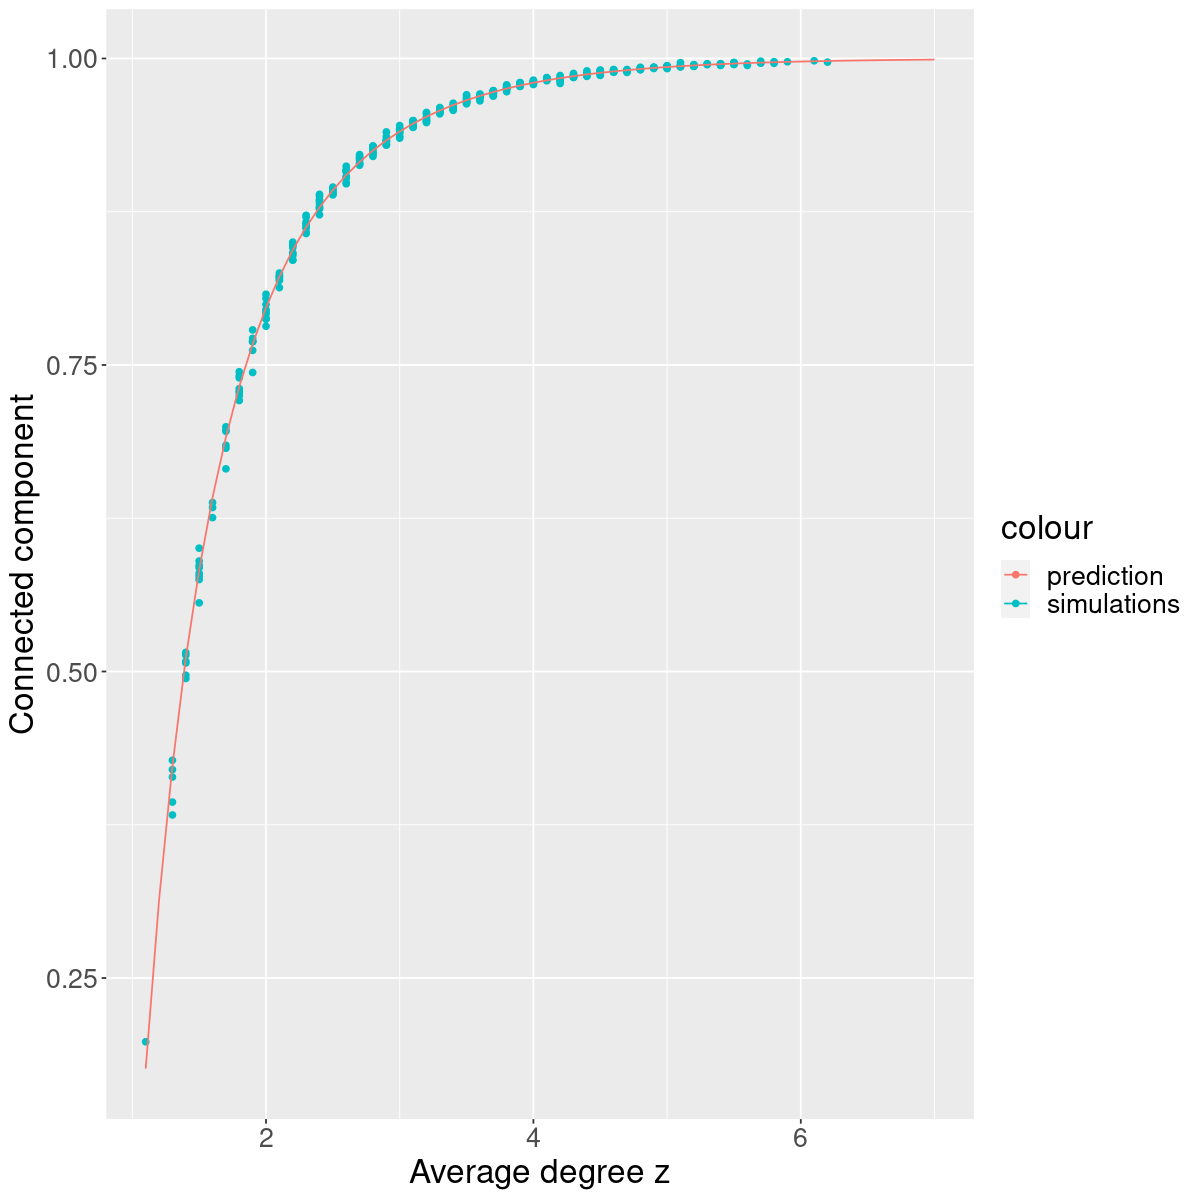

In [23]:
ggplot()+
    geom_point(data=df.cascade, aes(x=z, y=cascade.fraction, col='simulations'))+
    geom_line(data=prediction, aes(x=z, y=S, col='prediction'))+
    xlab(label = 'Average degree z')+
    ylab(label = 'Connected component')+
    theme(text = element_text(size = 20)) 

### Probability of cascade

#### Empirical probability of cascade

In [24]:
filename <- 'data/ERG_simulation_time.csv'

df <- read.csv(filename)

n.run <-10 #number of attemps for each configuration

#computing the theoretical prediction
count_prob <- df %>% group_by(z) %>% filter(cascade.fraction>0.1) %>% summarize(prob = n())
count_prob['prob']<- count_prob['prob']/n.run
z.values <- unique(df['z'])

#saving the prob for each simulation
prob <- merge(x = z.values, y = count_prob, by = 'z', all.x = TRUE) %>% mutate_all(~replace(., is.na(.), 0))

#### Computing the vulnerable connected component and extended vulnerable connected component

In [25]:
z.list <- seq(from=0.5, to=7, by=0.1) #value of z
n <- 10000 #number of nodes
phi <- 0.18 #threshold
n.run <- 10  #number of run

filename <- 'probability_prediction.csv' #file in which to save the predictions

In [26]:
#Reading the results from the saved file
prob_pred <- read.csv('data/probability_prediction.csv')

#### Comparison between data and prediction

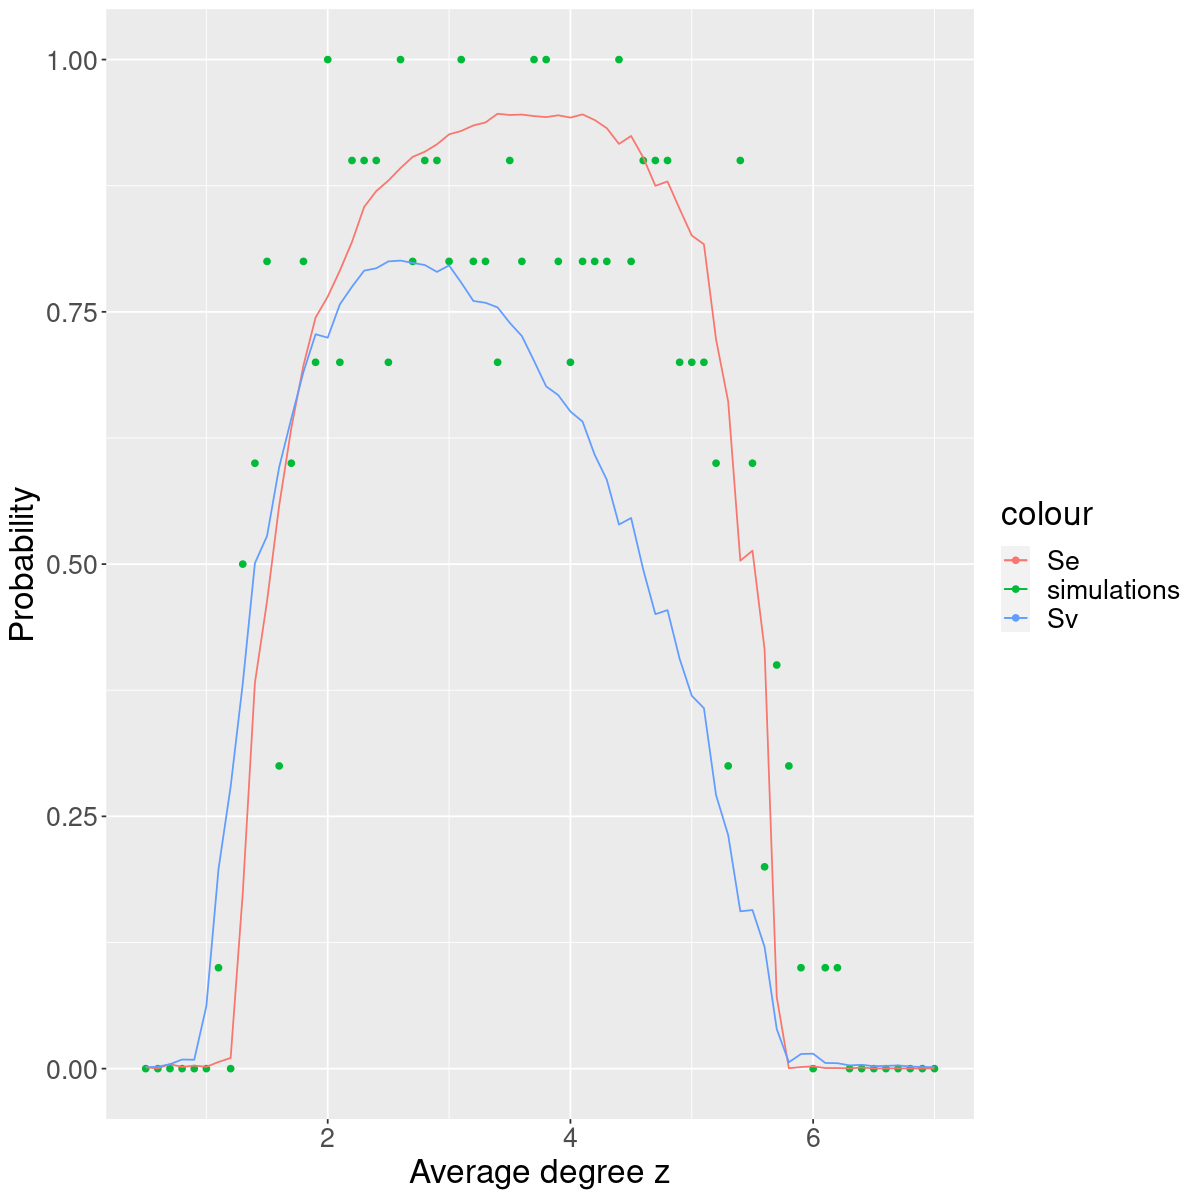

In [27]:
ggplot()+
    geom_point(data=prob, aes(x=z, y=prob, col='simulations'))+
    geom_line(data=prob_pred, aes(x=z, y=Se, col='Se'))+
    geom_line(data=prob_pred, aes(x=z, y=Sv, col='Sv'))+
    xlab(label = 'Average degree z')+
    ylab(label = 'Probability')+
    theme(text = element_text(size = 20)) 

### Homogeneous versus Heterogeneous thresholds

In [28]:
#function that take in input the csv with the data and returns the data for the plot
geom_step_cascade <- function(filename){  
    df <- read.csv(filename)
    data <- df %>% group_by(threshold, z)%>% arrange(desc(cascade.fraction), .by_group=TRUE) %>% filter(row_number()==1)
    cascade <- data %>% filter(cascade.fraction>=0.1)
    no_cascade <- data %>% filter(cascade.fraction <0.1)
    final.df <- cascade %>% group_by(threshold) %>% arrange(desc(z), .by_group=TRUE) %>% filter(row_number()==1)
    return(final.df)
}

In [29]:
#Uniform threshold
filename <- 'data/ERG_simulation_data.csv'
cascade_unif <- geom_step_cascade(filename)

In [30]:
#Normal distributed threshold with std=0.1
filename <- 'data/ERG_simulation_sigma0.1.csv'
cascade_st2 <- geom_step_cascade(filename)

In [31]:
#Normal distributed threshold with std=0.05
filename <- 'data/ERG_simulation_sigma0.05.csv'
cascade_st1 <- geom_step_cascade(filename)

#### Comparison between uniform and normally distributed threshold

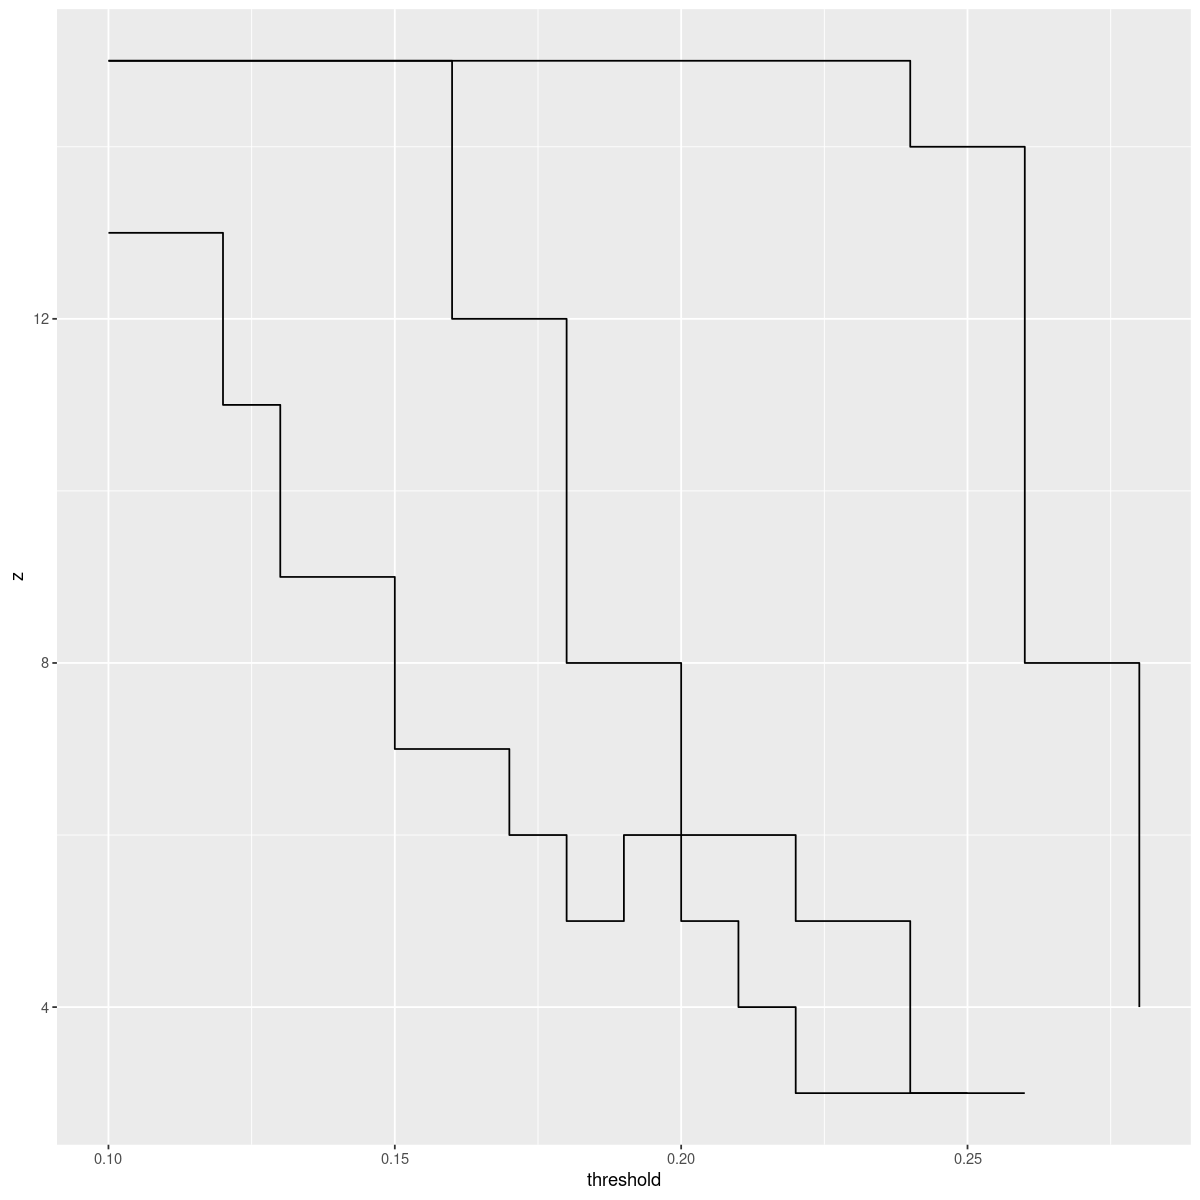

In [32]:
ggplot()+
    geom_step(data=cascade_st2, aes(x=threshold, y=z))+
    geom_step(data=cascade_st1, aes(x=threshold, y=z))+
    geom_step(data=cascade_unif, aes(x=threshold, y=z))

### Scale free network: Barabasi Albert simulation

In [33]:
#file with barabasi albert simulation data
filename <- 'data/BA_simulation_data.csv'
BA<- geom_step_cascade(filename)

##### Comparison with random graph and barabasi albert both with uniform threshold

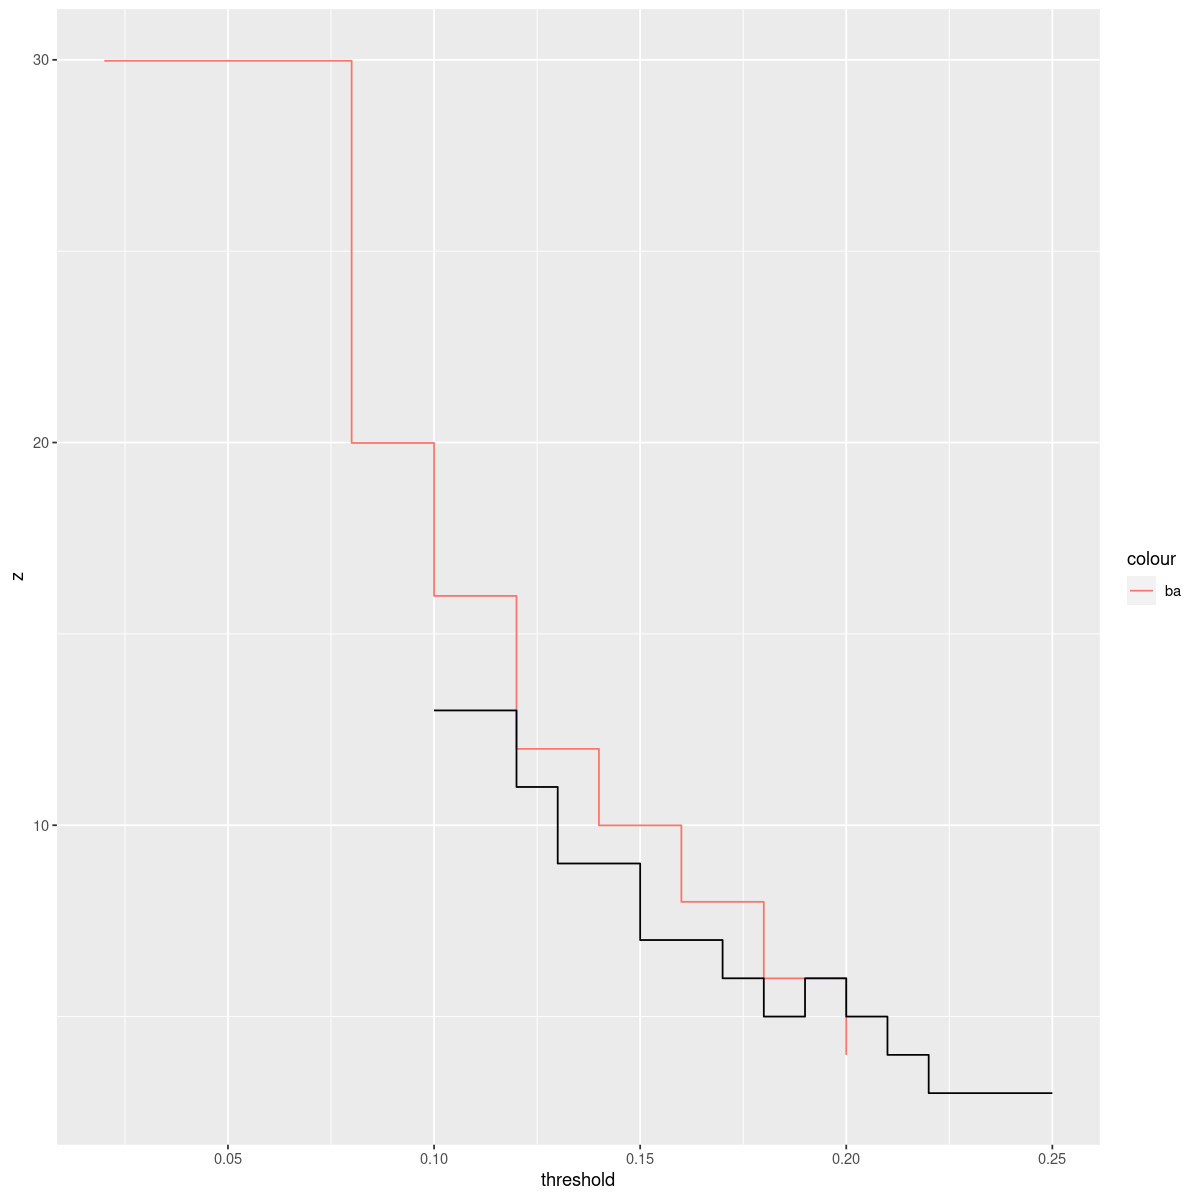

In [34]:
ggplot()+
    geom_step(data=BA, aes(x=threshold, y=z, col='ba'))+
    geom_step(data=cascade_unif, aes(x=threshold, y=z))